# Exam project

**Table of contents**<a id='toc0_'></a>    
- [Problem 1: Optimal taxation with government consumption](#toc1_)    
  - [Solution to question 1](#toc1_1_)    
  - [Solution to question 2](#toc1_2_)    
  - [Solution to question 3](#toc1_3_)    
  - [Solution to question 4](#toc1_4_)    
  - [Solution to question 5](#toc1_5_)    
  - [Solution to question 6](#toc1_6_)    
- [Problem 2: Labor adjustment costs](#toc2_)    
  - [Solution to question 1](#toc2_1_)    
  - [Solution to question 2](#toc2_2_)    
  - [Solution to question 3](#toc2_3_)    
  - [Solution to question 4](#toc2_4_)    
  - [Solution to question 5](#toc2_5_)    
- [Problem 3: Global optimizer with refined multi-start](#toc3_)    
  - [Solution to question 1](#toc3_1_)    
  - [Solution to question 2](#toc3_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import numpy as np
from scipy import optimize
import sympy as sm
from types import SimpleNamespace
from IPython.display import display
from scipy.stats import norm

import pandas as pd 
import matplotlib.pyplot as plt
import ipywidgets as widgets

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
from examproject import *

import time
start_time = time.time()

## <a id='toc1_'></a>[Problem 1: Optimal taxation with government consumption](#toc0_)


Consider a worker choosing hours of labor, $L\in[0,24]$, to maximize utility: 

$$
\begin{align*}
V(w,\tau,G)&=\max_{L\in[0,24]}\ln\left(C^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2}\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}
$$

where 

* $C$ is *private* consumption with weight $\alpha\in(0,1)$.
* $\kappa > 0$ is the *free private* consumption component.
* $C = (1-\tau)wL$ is the *costly private* consumption component.
* $w > 0 $ is the real wage.
* $\tau \in (0,1)$ is the labor-income tax rate.
* $G > 0 $ is *government* consumption with weight $1-\alpha$.
* $\nu > 0$ is the disutility of labor scaling factor


The baseline parameters are:

$$
\begin{align*}
\alpha &= 0.5\\
\kappa &= 1.0\\
\nu &= \frac{1}{2\cdot16^2} \\
w &= 1.0 \\ 
\tau &= 0.30 \\
\end{align*}
$$

**Question 1:** Verify that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

______________________________________________________________________________________________________

### <a id='toc1_1_'></a>[Solution to question 1](#toc0_)

**Step 1: Define the symbols, objective function and the consumption**

In [2]:
C = sm.symbols('C') # C is a Python variable representing the symbol C
G = sm.symbols('G')
L = sm.symbols('L')
w = sm.symbols('w')
wtilde = sm.symbols('wtilde')
alpha = sm.symbols('alpha')
nu = sm.symbols('nu')
kappa = sm.symbols('kappa')
tau = sm.symbols('tau')

In [3]:
objective = sm.log(C**alpha*G**(1-alpha))-nu*(L**2/2)
consumption = sm.Eq(C,kappa+(wtilde*L)) #wtilde = (1-tau)*w

**Step 2: Substitute consumption into the objective function**

In [4]:
objective_subs = objective.subs(C,consumption.rhs)

**Step 3: Find the first order condition w.r.t L**

In [5]:
foc = sm.diff(objective_subs,L)

**Step 4: Solve for L**

In [6]:
sol = sm.solve(foc,L)[1] 
sol

(-kappa*nu + sqrt(nu*(4*alpha*wtilde**2 + kappa**2*nu)))/(2*nu*wtilde)

We can verify that this is the same as the expression of interest by expanding the expression above in the following way:

$\begin{aligned} & L^{\star}(\tilde{w}) = \frac{-\kappa v+\sqrt{v\left(4 \alpha \tilde{w}^2+\kappa^2 v\right)}}{2 v \widetilde{w}}=-\frac{\kappa}{2 \widetilde{w}}+\frac{\sqrt{v\left(4 \alpha \widetilde{w}^2+\kappa^2 v\right)}}{2 v \widetilde{w}}=-\frac{\kappa}{2 \widetilde{w}}+\frac{\sqrt{v\left(4 \alpha \widetilde{w}^2+\kappa^2 v\right)}}{2 \widetilde{w} \sqrt{v^2}} \\ & =-\frac{\kappa}{2 \widetilde{w}}+\frac{\sqrt{\frac{1}{v}\left(4 \alpha \widetilde{w}^2+\kappa^2 v\right)}}{2 \widetilde{w}}=-\frac{\kappa}{2 \widetilde{w}}+\frac{\sqrt{4 \frac{\alpha}{v} \widetilde{w}^2+\kappa^2}}{2 \widetilde{w}}=\frac{-\kappa+\sqrt{\kappa^2+4 \frac{\alpha}{v} \widetilde{w}^2}}{2 \widetilde{w}}\end{aligned}$

**Step 5: Construct numerical solver to maximize utility wrt. labor supply, $L$, and compare analytical and numerical solution for $G\in\left\{1.0 , 2.0\right\}$**

*Procedure to construct numerical solver*:
1. Setup baseline parameters in `self.__init__()` in the class `OptimalTaxation()`

2. Formulate the utility function in `self.calc_utility()`. We use monotonicity and substitute $C$ with the budget constraint in the utility function, hence we do not have to define any constraints in step 3. Depending on the problem, three different utility functions are defined. For this problem, we focus on the utility when `extension=False` and `CES=False`.

3. Now, we solve the model in `self.solve_model()`. Objective function and bounds are defined. As we use a numerical constraint optimizer that solves the argument by minimizing the objective function, we need to define the negative of the utility function as the objective function. The bounds ensures that the labor supplied is non-negative and cannot exceed 24 (as this is the maximum hours in a day). As this an unconstrained problem, the solution is found by using the `scipy.optimize.minimize_scalar()` function and specify `method=bounded`. 

Below we solve the problem numerically for $G\in\left\{1.0 , 2.0\right\}$

In [7]:
model = OptimalTaxation()
for G in range(1,3):
    model.par.G = G
    print(f'For G={G}:')
    model.solve(do_print=True)
    print('')

For G=1:
Optimal labor supply is 15.30

For G=2:
Optimal labor supply is 15.30



We see that the optimal labor supply does not depend on the value of G, because changing G does not affect the income through any channels in this problem.

**Step 6: Compare with analytical solution**    

$$L^*(\tilde{W})=\frac{-1+\sqrt{1^2+4*\frac{0.5}{\frac{1}{2*16^2}*[(1-0.3)*1]^2}}}{2*(1-0.3)*1}=15.30$$

Which is the same as the numerical solution.

______________________________________________________________________________________________________

**Question 2:** Illustrate how $L^{\star}(\tilde{w})$ depends on $w$.

______________________________________________________________________________________________________

### <a id='toc1_2_'></a>[Solution to question 2](#toc0_)

*Procedure*
1. To illustrate how $L^{\star}(\tilde{w})$ depends on $w$, we use the numerical solver specified in **Question 1** and solve the model for a discrete set of 100 different wages in a range from 0.5 to 5.0. The code for this is implemented in `self.solve_w_vec()`. The solution is stored in a list containing the optimal labor supply for the given wage.  

2. Next, we plot the optimal labor supply as a function of the wage in `self.plot_L()`.

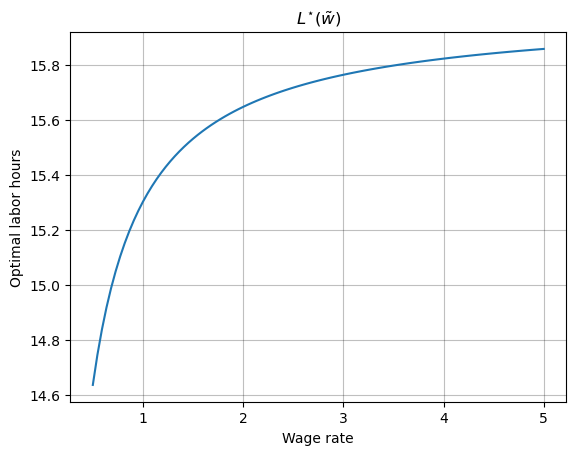

In [8]:
model = OptimalTaxation() # reset parameter values to baseline
model.plot_L()

From the plot it is apparent that the positive substitution effect on labor supply from a wage increase dominates the negative income effect at all given wages. Thus as the wage increases the optimal labour supply will increase as well. We also observe that the marginal effect on optimal labor hours from a wage increase is decreasing in the wage, which must be due to that the substitution- and income effect gets numerically closer to each other as the wage increases.

______________________________________________________________________________________________________


We now consider a government, who chooses $\tau$ and spend all of the taxes on government consumption so:

$$
G = \tau w L^{\star}((1-\tau)w)
$$

**Question 3:** Plot the implied $L$, $G$ and worker utility for a grid of $\tau$-values.


______________________________________________________________________________________________________

### <a id='toc1_3_'></a>[Solution to question 3](#toc0_)

*Procedure*


1. Reset parameter values

2. We solve the model for the case where government consumption is determined endogenously in `self.solve()`.

3. We solve the model for different $\tau$-values in `self.solve()`. We define a vector of $\tau$-values and then loop over the vector and solve the model for each $\tau$. The solution is saved in a vector containing the optimal labor supply, government consumption and utility for the given $\tau$-value.

4. Finally, we plot the optimal labor supply, government consumption and utility as a function of $\tau$ in `self.plot_results()`.

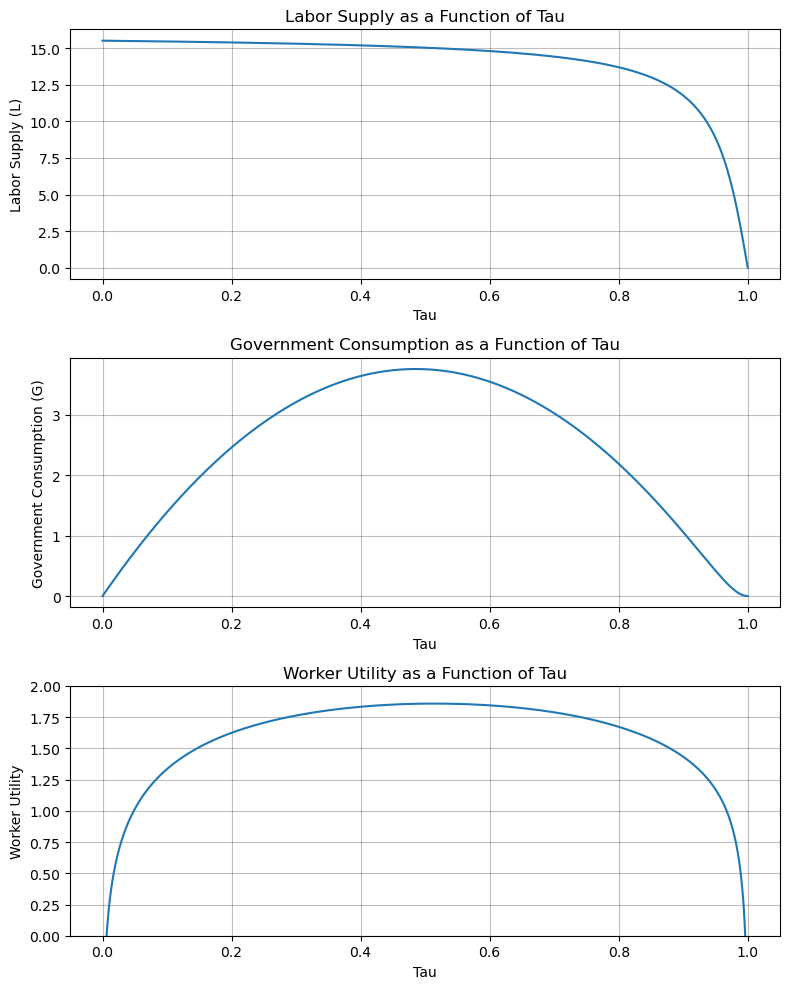

In [9]:
model = OptimalTaxation() # reset parameter values to baseline
tau_grid = np.linspace(0.000001,0.999999,1000) #grid of tau values. 
model.plot_results(tau_grid=tau_grid, extension=True)

**Labor supply as a function of $\tau$:** It is seen in the first plot that the labor supply is decreasing in $\tau$. This is because the higher the tax rate, the less attractive it is to work. 

**Government consumption as a function of $\tau$:** Government consumption is first increasing in $\tau$, up utill some point whereafter it starts to decrease. This is because the higher the tax rate, the more money the government has to spend on government consumption, but at some point the tax rate is so high that the worker does not want to work anymore and therefore the government consumption decreases. 

**Worker utility as a function of $\tau$:** Worker utility is first increasing in $\tau$, up utill some point whereafter it starts to decrease. This is because the worker gets utility both from consumption and from government consumption. However at some point, the disutility of working is going to outweigh the utility from government consumption and therefore the worker utility decreases as $\tau$ increases.

______________________________________________________________________________________________________

**Question 4:** Find the socially optimal tax rate $\tau^{\star}\in(0,1)$ maximizing worker utility. Illustrate your result.

______________________________________________________________________________________________________

### <a id='toc1_4_'></a>[Solution to question 4](#toc0_)

*Procedure*

1. Define a function that finds the optimal tax rate that maximizes the worker utility. The function is defined in `self.optimal_tax_cd()`. The function takes the baseline parameters as input and returns the optimal tax rate. We use `optimize.minimize_scalar` and specify `method=bounded` to solve for the optimal tax rate.

2. We plot the optimal tax rate in the plots from question 3. 

In [10]:
model.optimal_tax_cd(extension=True, do_print=True)

The tax rate that maximizes workers utility is 0.51


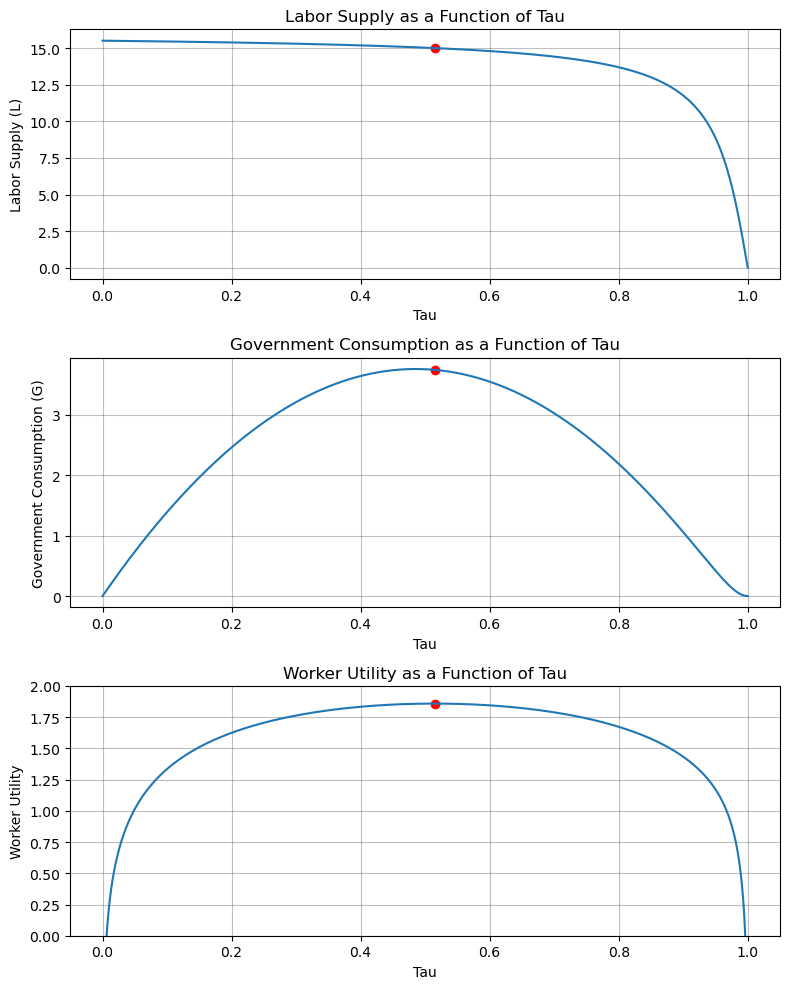

In [11]:
model.plot_results(tau_grid=tau_grid, extension=True, optimal_tax=True)

The optimal tax rate is plotted in each of the plots. It is seen that the optimal tax rate is around 0.51. 

______________________________________________________________________________________________________

A more general preference formulation for the worker is:

$$
\begin{align*}
\mathcal{V}(w,\tau,G)&=\max_{L\in[0,24]}\frac{\left[ \left( \alpha C^{\frac{\sigma-1}{\sigma}}+(1-\alpha) G^{\frac{\sigma-1}{\sigma}} \right)^{\frac{\sigma}{1-\sigma} }\right]^{1-\rho}-1}{1-\rho}- \nu\frac{L^{1+\varepsilon}}{1+\varepsilon},\,\,\,\varepsilon,\rho,\sigma>0,\,\,\,\rho,\sigma\neq1\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}    
$$

Optimal labor supply is now $L^{\star}(\tilde{w},G)$.

Questions 5 and 6 must be answered with the general formulation, and for 2 different set of parameters:

- Set 1:  $\sigma = 1.001$, $\rho = 1.001$ and $\varepsilon = 1.0$.
- Set 2:  $\sigma = 1.5$, $\rho = 1.5$ and $\varepsilon = 1.0 $.

**Question 5:** Find the $G$ that solves $G = \tau w L^{\star}((1-\tau)w,G)$ using the $\tau$ found in question 4.

*Hint: First write code that solves the worker problem for given values of $G$ and $\tau$. Then find the correct G based on this.*

______________________________________________________________________________________________________

### <a id='toc1_5_'></a>[Solution to question 5](#toc0_)

*Procedure*

1. A function `self.solve_G()` is defined. The function calculates government consumption from the taxrate found in previous question. 

2. We define $\tau$ as an argument to the function, which when we call on it below should be set equal to the optimal tax rate found in `self.optimal_tax_cd()`. 

2. An objective funtion is now defined by substituting $L^{\star}((1-\tau)w,G)$ with the function that solves the worker problem for given values of $G$ and $\tau$, i.e. `self.solve()`, in $G = \tau w L^{\star}((1-\tau)w,G)$. 

3. Finally, we use `optimize.root` to find the root of the objective function. This minimizer finds the government consumption G that solves  $G = \tau w L^{\star}((1-\tau)w,G)$. We specify the intial guess as 5. 

In [12]:
model = OptimalTaxation() # reset parameter values to baseline
model.solve_G(tau=model.optimal_tax_cd(extension=True))
print(f'The correct government consumption for parameter set 1 is: {model.sol.G_opt:.3f}')
print('')
model.solve_G(tau=model.optimal_tax_cd(extension=True), set_2=True)
print(f'The correct government consumption for parameter set 2 is: {model.sol.G_opt:.3f}')

The correct government consumption for parameter set 1 is: 7.711

The correct government consumption for parameter set 2 is: 4.975


**Intuition:** With the first set of parameters, the more generel preferance formulation is approximately the same as the one used in previous questions. The optimal government consumption therefore is the same as we see in the plots from the previous question. When the second parameter set is used, the optimal government consumption falls. This is because the increase of $\sigma$ and $\rho$, makes the elasticity of consumption less than 1. That is the worker can not substitute consumption for government consumption as much as before. Therefore the optimal government consumption falls.

______________________________________________________________________________________________________

**Question 6:** Find the socially optimal tax rate, $\tau^{\star}$, maximizing worker utility, while keeping $G = \tau w L^{\star}((1-\tau)w,G)$.

______________________________________________________________________________________________________

### <a id='toc1_6_'></a>[Solution to question 6](#toc0_)

*Procedure* 
1. A function `self.optimal_tax_ces()` is defined. The function calculates the optimal tax rate the maximizes worker utility keeping $G = \tau w L^{\star}((1-\tau)w,G)$ for either the first or the second set of parameters. 

2. First an objective function is defined. The objetive function takes $\tau$ as an argument and returns the negative of the utility function `self.calc_utility()`.

3. The arguments specified in the utility function are:
    * For L we specify the optimal labor supply returned in `self.solve(G,tau)`. The keyword-argument G is set equal to the G returned from `self.solve_G(tau)` for the given argument `tau`, and `tau` is set equal to the argument `tau` of the objective function.
    * G is set equal to the G returned from `self.solve_G(tau)` for the given argument `tau`
    * `tau` is set to the argument `tau`

4. Finally, we call the `optimize.minimize_scalar()`-method to minimize the objective function with relation to $\tau$. Thereby, we get the optimal tax rate.

In [13]:
model = OptimalTaxation() # reset parameter values to baseline
model.optimal_tax_ces()
print(f'The optimal tax rate for parameter set 1 is: {model.sol.tau_opt:.7f}')
print('')
model = OptimalTaxation() # reset parameter values to baseline
model.optimal_tax_ces(set_2=True)
print(f'The optimal tax rate for parameter set 2 is: {model.sol.tau_opt:.7f}')

The optimal tax rate for parameter set 1 is: 0.0000060

The optimal tax rate for parameter set 2 is: 0.0000060


The results does not seem meaningful, but we couldn't figure out what was wrong in our code.

## <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each haridresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

_______________________________________________________________________________________________________________________________

### <a id='toc2_1_'></a>[Solution to question 1](#toc0_)

Firstly, we calculate the analytical solution for $\kappa_{t} = 1.0$ and $\kappa_{t} = 2.0$ given the expression for $\ell_t$:

**For $\kappa_{t} = 1.0$**

$\ell_{t}=\left(\frac{(1-\eta)*\kappa_{t}}{w}\right)^{\frac{1}{\eta}}=\left(\frac{(1-0.5)*1}{1.0}\right)^{\frac{1}{0.5}}=0.25$

**For $\kappa_{t} = 2.0$:**

$\ell_{t}=\left(\frac{(1-\eta)*\kappa_{t}}{w}\right)^{\frac{1}{\eta}}=\left(\frac{(1-0.5)*2}{1.0}\right)^{\frac{1}{0.5}}=1$

Next, we calculate the optimal numerical solution for $\ell_t$ given $\kappa_{t} = 1.0$ and $\kappa_{t} = 2.0$, our baseline parameters and the profit function. That is, we calculate the optimal $\ell_t$ that maximizes profits for $\kappa_{t} = 1.0$ and $\kappa_{t} = 2.0$, respectively.

We do this by calling on the function `find_optimal_lt()` in the `LaborAdjustmentCosts()`-class in `examproject.py`.

This function loops over the values of $\kappa_t$ and calculates the value of $\ell_{t}$ that maximizes profits.

In [14]:
model = LaborAdjustmentCosts() # create an instance of the model
model.find_optimal_lt() #call the function that calculates optimal labor supply

For kappa = 1.0 the optimal labor supply is lt = 0.25 which yields profits of 0.25 

For kappa = 2.0 the optimal labor supply is lt = 1.00 which yields profits of 1.00 



We see that the numerical solution is equal to the analytical solution for both values of $\kappa_{t}$. We can therefore numerically verify that it is exactly for $\kappa_t=1$ and $\kappa_t=2$ that profits are maximized.

_______________________________________________________________________________________________________________________________

We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$


The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K-1} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

_______________________________________________________________________________________________________________________________

### <a id='toc2_2_'></a>[Solution to question 2](#toc0_)

To calculate H if the policy $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ is followed, we implement the following procedure in the `LaborAdjustmentCosts()`-class in `examproject.py`:

1.  Formulate functions for optimal labor rule and profits as specified above. These are defined in `self.optimal_labor_rule(kappat)` and `self.profits_func(kappat,lt,lt_prev)`. Both functions takes $\kappa_t$ as an argument, and moreover the profit function takes $l_t$ and $l_{t-1}$ as arguments.

2. Set random seed.

3. Next, we use a for loop to iterate over each of the $K$ random shock series, where we for each shock series draw $T$ random values of $\epsilon_t$ from $\mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})$. Moreover, we also specify $\kappa_{-1},l_{-1}$ and $h_{-1}$ within this loop.

4. For each of $K-1$ random shock series, we now use a for loop again (and thereby using a nested loop) to loop over each of the $T$ periods in the time horizon. For each $k,t$, we calculate the demand shock $\kappa_{t}^k$ and from this value we compute optimal labor supply using the `self.optimal_labor_rule(kappat)`-function (for this problem ignore the if-statements `extension` and `Delta\neq0` and focus on `Delta==0`) and next we find the implied profits using the `self.profits_func(kappat,lt,lt_prev)`-function. Finally, we use the profits to compute the added value of the salon for $k,t$, namely: $R^{-t}\left[\kappa_{t}^{k}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]$, and add this value to $h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)$.

5. Set `lt_prev` and `kappat_prev` equal to respectively `lt` and `kappat`, and continue to the next iteration in the nested loop $k,t+1$.

6. After looping over all T time periods, we define a list of $K$ elements consisting of each shock series' $h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)$.

7. Finally, outside the nested loop we calculate the average value function, $H$, by finding the mean of the list defined in step 6.

Step 2-7 are all implemented in the method `self.calc_H()`.


To calculate H with $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$, we call on the function `py.calc_H` in the `LaborAdjustmentCosts`-class in `exam.py`. Furthermore, we specify `do_print=True` to print the value of H. For now, we set $K=1000$ and evaluated the result.

In [15]:
H = model.calc_H(K=1000,do_print=True) # calculate H for K=1000

For K=1000 the value of H is 27.649



From this, we see that if $K=1000$ then we get that $H\approx27.649$ when the salon is following the optimal labor policy. 

We note that the result we get is only an approximation of $H$, because we have set a finite number of shock series, namely $K=1000$. We know from the Law of Large Numbers (LLN) that if we let K go to infinity, the approximation error of H will go to zero (the sample moment converges to theoretical moments). However, because of the regards to computational power and computational time, letting K go to infinity will not be reasonable. 

Therefore, in `self.estimate_K()`-method we seek to find an "optimal" K when taking the trade-off between approximation bias and computational efficiency in consideration. We implement this by looping over each 500th value of $K$ in a range between 500 and 6000. If the absolute change in $H$ from the previous to the current iteration is below a specified tolerance, `tol`, we say that we have found a $K$ such that the approximation of $H$ is good enough to not affect our results substantially. 

Below we have specified `tol=0.01`. Next, we print and plot the results. From this we see that K should be set equal to 3500, which is also denoted by the orange dot in the plot. For the next problems we will therefore specify K as 3500.

By comparing H for different values of K in the range between 500 and 6000 with a step size of 500, we choose K to be 3500


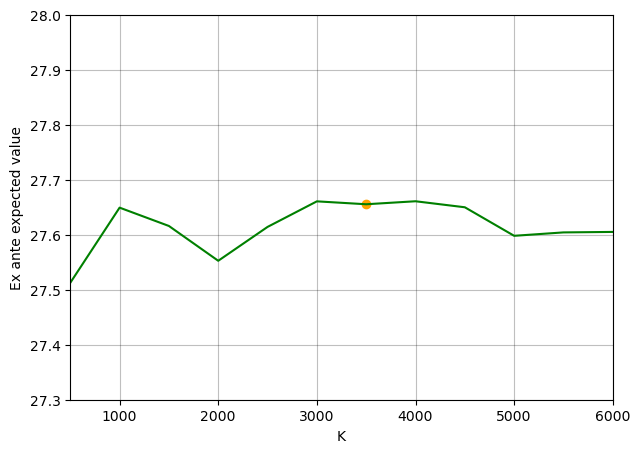

In [16]:
model.estimate_K(tol=1e-2)

Below we have calculated the ex ante expected value function for $K=3500$.


In [17]:
H = model.calc_H(K=model.sol.K,do_print=True) # calculate H for K=3500

For K=3500 the value of H is 27.655



We find that this new value of $H=27.655$ is slightly higher than the value of $H=27.649$ we found when $K=1000$. When we use use a larger number of shock series to approximate H, we reduce the approximation bias which has changed the resulting $H$.

_______________________________________________________________________________________________________________________________

Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

_______________________________________________________________________________________________________________________________

### <a id='toc2_3_'></a>[Solution to question 3](#toc0_)

The new policy essentially means that the hairsalon will only adjust its labor force if the change between last periods labor force and the optimal labor force in the current period is greater than some threshold $\Delta$. 

- If the change in labor force is less than $\Delta$, the firm will keep the same labor force as in the previous period. 
- If the change in labor force is greater than $\Delta$, the firm will adjust its labor force to the optimal labor force in the current period.


The function `py.calc_H()` has been expanded for question 2. Therefore, it is possible to specify the value of $\Delta$ as a keyword argument. 

The addition to the function works by following a new definition of $\ell_t$ corresponding to the one described above in the case where $\Delta > 0$. However, the baseline specification of the model continues to be $\Delta=0$.

In [18]:
H = model.calc_H(Delta=0.05, do_print=True) # calling calc_H with Delta = 0.05

For K=3500 and Delta=0.05 the value of H is 28.337



We find that **the ex ante expected value of the salon over the planning horizon of 10 years is $H=28.337$** when $\Delta=0.05$. 

We see that the new policy improves the expected value of the salon by roughly 0.7.

The intuition behind the result is that if the firm keeps adjusting the labor force every period, they will incur adjustment/hiring costs each period. So, the result tells us that in some periods it will be optimal to keep the labor force unchanged.

_______________________________________________________________________________________________________________________________

**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

_______________________________________________________________________________________________________________________________

### <a id='toc2_4_'></a>[Solution to question 4](#toc0_)

To find the optimal $\Delta$ that maximizes $H$, we use the function `py.max_H()` in the `LaborAdjustmentCosts()`-class in `examproject.py`.

This function uses the `nelder-mead` optimizer to find the value of $\Delta$ that maximizes the ex ante expected value of the salon ($H$) and returns the value of $\Delta$ as well as the appertaining value of $H$.

Next, we use the function `py.max_H()` to plot $H$ against $\Delta$. To do this, we loop over 50 evenly spaced values of $\Delta$ and calcultate $H$ for each value of $\Delta$. We then plot the values of $H$ against the values of $\Delta$ using `matplotlib` with the function `py.plot_Delta()`.

In [19]:
model.max_H(K=3500) # the function py.max_H() finds the Delta that maximizes H

H is maximized for Delta = 0.076, implying H=28.392


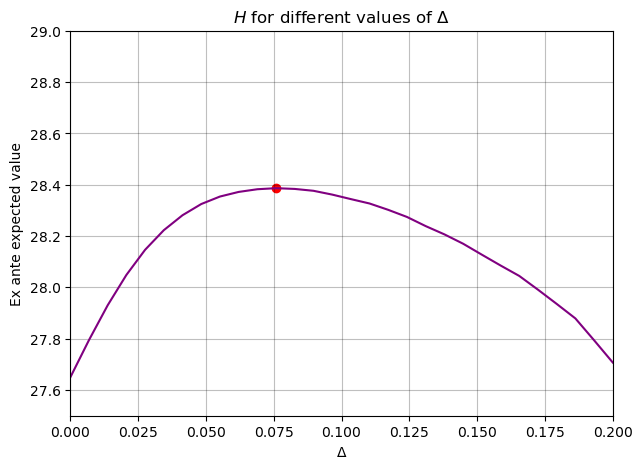

In [20]:
model.plot_Delta(K=1000) # We set K=1000 for the plot because of regards to reduce the computational time

From the results above, we can conclude that the **the ex ante expected value of the salon over the planning horizon of 10 years is maximized at $H=28.392$ when $\Delta=0.076$**.

For the $0<\Delta<0.076$ we see that the labor force is adjusted too often, so the adjustment costs actually dominate the gain from adjusting the labor force. Therefore, none of these values of $\Delta$ are the optimal solution.

Conversely, if $\Delta>0.076$ we see that the labor force is adjusted too seldom, so the gain from adjusting the labor force dominates the adjustment costs. Since the profits could be increased from adjusting the labor force more often, these solutions are not optimal either.

The best balance between adjustment costs and added value of adjusting the labor force are thus found at $\Delta=0.076$ **as highlighted in the plot above**.

_______________________________________________________________________________________________________________________________


**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.



_______________________________________________________________________________________________________________________________

### <a id='toc2_5_'></a>[Solution to question 5](#toc0_)

To improve profitability, we suggest that decision to adjust the labor force should be evaluated not from whether the change in staff is larger than some threshold $\Delta$, but rather from whether the change in the labor force will increase profits in the given period.

Thus, we suggest the following specification of $\ell_t$:
$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if } \quad \pi(\ell^{\ast}) > \pi(\ell_{-1})\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{ }
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \quad \text{and} \quad \pi(\ell_{t}) = \kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota \\

$$


In [21]:
H = model.calc_H(K=3500,do_print=True,extension=True)

For K=3500 the value of H is 28.395



With our extension of the model, we find that we are able to increase H marginally with $0.03$ to $H=28.395$. 

This might be due to the fact that the condition for whether or not the staff should be adjusted is evaluated based on the specific profit possibilities in the given period, and not based on some exogenous threshold $\Delta$ that stays constant throughout all periods.

## <a id='toc3_'></a>[Problem 3: Global optimizer with refined multi-start](#toc0_)

We consider the Griewank function:

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+1$$

The **global minimum** of this function is $f(0,0) = 0$ (remember: $\cos(0)=1$).<br>
But the function also have a lot of **local minima**.

In [22]:
def griewank(x):
    return griewank_(x[0],x[1])
    
def griewank_(x1,x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1))*np.cos(x2/np.sqrt(2))
    return A-B+1

A **refined global optimizer with multi-start** is:

1. Choose *bounds* for $\mathbf{x}$ and *tolerance* $\tau > 0$.
2. Choose number of *warm-up iterations*, $\underline{K} > 0$ and *maximum number of iterations*, $K > \underline{K}$.
3. In each iteration for $k \in \{0,1,\dots,K-1\}$:

    A. Draw random $\mathbf{x}^k$ uniformly within chosen bounds.

    B. If $k < \underline{K}$ go to step E.

    C. Calculate $\chi^k = 0.50\cdot\frac{2}{1+\exp((k-\underline{K})/100)}$  

    D. Set $\mathbf{x}^{k0} = \chi^k \mathbf{x}^k + (1-\chi^k)\mathbf{x}^{\ast} $

    E. Run optimizer with $\mathbf{x}^{k0}$ as initial guess and $\mathbf{x}^{k\ast}$ as result.

    F. Set $\mathbf{x}^{\ast} = \mathbf{x}^{k\ast}$ if $k = 0$ or $f(\mathbf{x}^{k\ast}) < f(\mathbf{x}^{\ast})$

    G. If $f(\mathbf{x}^{\ast}) < \tau$ go to step 4.

4. Return the result $\mathbf{x}^{\ast}$.

As settings we choose:

* $x_1,x_2 \in  [-600,600]$
* $\tau = 10^{-8}$
* $\underline{K}=10$
* $K=1000$

The optimizer in Step 3.E is `BFGS` with a tolerance of $\tau$.

**Question 1:** Implement the refined global optimizer with multi-start. Illustrate how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$.

______________________________________________________________________________________________________________________

### <a id='toc3_1_'></a>[Solution to question 1](#toc0_)

The refined global optimizer with multi-start is implemented in the class `Problem3()` in the py-file. The functions are implemented as specified by the pseudo-algorithm above, and the solution is found and printed in `self.global_optimizer()`

Below we have printed the convergence towards the global minimum. We see that after 365 iterations, the algorithm finds the correct global minimum.

In [23]:
model = Problem3() # call instance of class
model.global_optimizer() # implement global optimizer and print solution

   0: Effective initial guess = ( 364.11,  33.03) -> converged at ( 364.24,  35.51) with f =  33.50021697
   1: Effective initial guess = (-457.07, 167.62) -> converged at (-458.44, 168.66) with f =  59.68725094
   2: Effective initial guess = (-490.89,-201.33) -> converged at (-489.84,-204.16) with f =  70.44777075
   3: Effective initial guess = ( -87.14,  65.26) -> converged at ( -84.78,  66.58) with f =   2.90705642
   4: Effective initial guess = ( 153.75, 236.87) -> converged at ( 153.86, 235.24) with f =  19.76920515
   5: Effective initial guess = ( 347.94,-441.73) -> converged at ( 348.53,-439.39) with f =  78.70208398
   6: Effective initial guess = (-188.68,-358.13) -> converged at (-188.40,-355.07) with f =  40.42906777
   7: Effective initial guess = ( 248.79,-559.92) -> converged at ( 251.19,-559.22) with f =  94.04833711
   8: Effective initial guess = ( 491.10,-113.81) -> converged at ( 489.84,-115.40) with f =  63.34899883
   9: Effective initial guess = ( 312.52, -31.

Below, we have illustrated how the effective initial guesses $x_1^{k0}$ and $x_2^{k0}$ vary with the iteration counter $k$. We see that both variables fluctuates around the true optimizing values, and as the iteration increases the deviations from the true optimizing values decreases. As we saw above the global minimum of the Griewank function is found after 365 iterations.

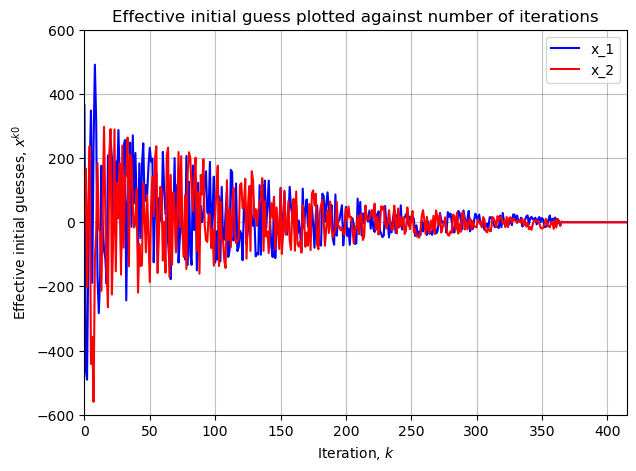

In [24]:
model.plot() # plot effective initial guesses against iterations

______________________________________________________________________________________________________________________

**Question 2:** Is it a better idea to set $\underline{K} = 100$? Is the convergence faster?

______________________________________________________________________________________________________________________

### <a id='toc3_2_'></a>[Solution to question 2](#toc0_)

We can test if the convergence is faster and illustrate what happens when we set $\underline{K} = 100$

   0: Effective initial guess = ( 364.11,  33.03) -> converged at ( 364.24,  35.51) with f =  33.50021697
   1: Effective initial guess = (-457.07, 167.62) -> converged at (-458.44, 168.66) with f =  59.68725094
   2: Effective initial guess = (-490.89,-201.33) -> converged at (-489.84,-204.16) with f =  70.44777075
   3: Effective initial guess = ( -87.14,  65.26) -> converged at ( -84.78,  66.58) with f =   2.90705642
   4: Effective initial guess = ( 153.75, 236.87) -> converged at ( 153.86, 235.24) with f =  19.76920515
   5: Effective initial guess = ( 347.94,-441.73) -> converged at ( 348.53,-439.39) with f =  78.70208398
   6: Effective initial guess = (-188.68,-358.13) -> converged at (-188.40,-355.07) with f =  40.42906777
   7: Effective initial guess = ( 248.79,-559.92) -> converged at ( 251.19,-559.22) with f =  94.04833711
   8: Effective initial guess = ( 491.10,-113.81) -> converged at ( 489.84,-115.40) with f =  63.34899883
   9: Effective initial guess = ( 312.52, -31.

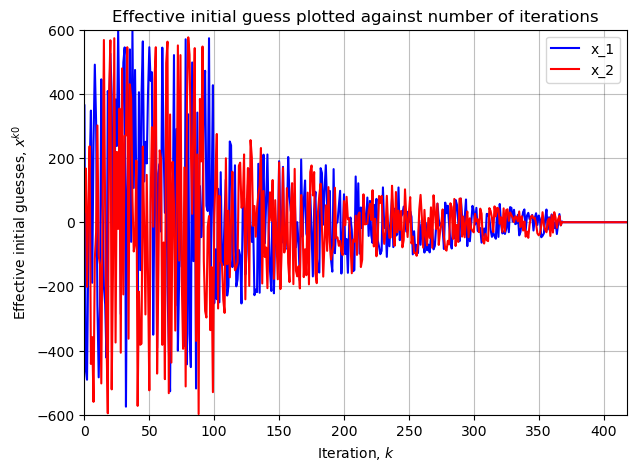

In [25]:
model = Problem3() # call instance of class
model.par.K_warm = 100 # change warm-ups to 100

# Solve and plot model
model.global_optimizer() # implement global optimizer and print solution
print("\n")
model.plot() # plot effective initial guesses against iterations


From the prints above, we see that the speed of convergence has now increased to 415 iterations by increasing $\underline{K}$ to 100. From the plot it is apparent that increasing $\underline{K}$, i.e. increasing the number of *warm-up iterations*, will obviously slow up the convergence towards the global minimum.

 The intuition is that in the 100 *warm-up iterations* where the guesses are just randomly drawn from a uniform distribution, the solver wrongly converges to many of the local minima. Moreover, the deviation from the global optimum does not converge towards 0 when we increase the number of iterations. 
 
 However, after the 100 *warm-up iterations*, we start defining our effective initial guesses $\mathbf{x}^{k0}$ as a weighted average of the random draw, $x^k$, and the previous initial guess that returns the so far lowest function value, $x^*$. By exploiting previous evalutions that returns low function values, we see a very clear picture from the graph above that just after the 100th iteration our effective initial guesses starts deviating less from the global optimum, and that they starts converging towards the global optimum when we increase the number of iteration.




Thus, if we instead decreased $\underline{K}$, we would lower the speed of convergence. However, lowering $\underline{K}$ to 1 would probably not be optimal regarding speed of convergence, because this would imply that $\mathbf{x}^{k0}$ would only be based on one previous random draw in the first iteration following the warm-up iteration. If this random draw is far away from the global optimum the next iterations would naturally also be more imprecise as there is a high dependency on this first draw. However, if we do a few warm-up iteration we lower the risk of extreme random draws slowing down the convergence of the algortihm.

Below, we have tried to find the optimal value of $\underline{K}$ regarding the speed of convergence. We have done this in `self.estimate()`, where we estimate the optimum value of $\underline{K}$ by looping through a list of integer values in the range from 1 to 40, and then the algorithm returns the $\underline{K}$ that minimizes the number of iterations.

In [26]:
K_warm_opt = model.estimate() # estimate optimal warm-ups

The number of warm-up iterations maximizing speed of convergence is 4.
This implies 95 iterations before convergence to global optimum is obtained.


So, if we set $\underline{K}=4$, we will maximize the speed of convergence towards the global optimum. We can plot this as:

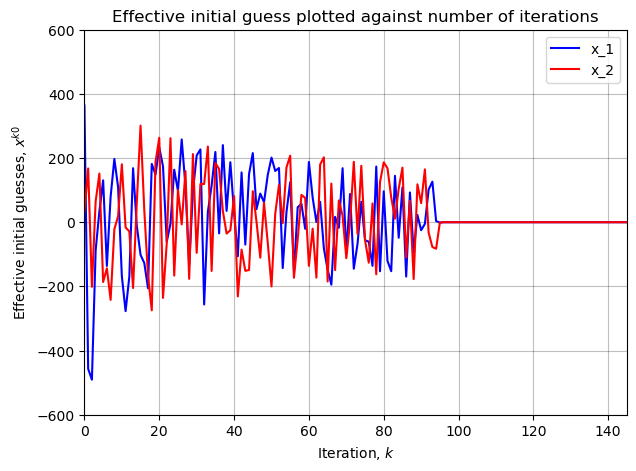

In [27]:
model.par.K_warm = K_warm_opt # change warm-ups to optimal number of warm-ups
model.global_optimizer(do_print=False,do_plot=True)


In [28]:
# how many minutes did it take to run the code?
print("Process finished --- %s minutes ---" % ((time.time() - start_time)/60))

Process finished --- 2.8141732533772785 minutes ---
